In [91]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import os


In [92]:
solar_data = pd.read_csv('efficiency.csv')
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  3699 non-null   int64  
 1   Unnamed: 0    3699 non-null   int64  
 2   p_state       3699 non-null   object 
 3   p_county      3699 non-null   object 
 4   ylat          3699 non-null   float64
 5   xlong         3699 non-null   float64
 6   p_area        3699 non-null   int64  
 7   p_tech_sec    3699 non-null   object 
 8   p_axis        3436 non-null   object 
 9   p_azimuth     3699 non-null   int64  
 10  p_tilt        3265 non-null   float64
 11  p_cap_ac      3699 non-null   float64
 12  p_cap_dc      3699 non-null   float64
 13  p_type        3699 non-null   object 
 14  p_agrivolt    3699 non-null   object 
 15  p_zscore      3699 non-null   float64
 16  efficiency    3699 non-null   float64
dtypes: float64(7), int64(4), object(6)
memory usage: 491.4+ KB


In [93]:
solar_data['p_axis'] = solar_data['p_axis'].replace({
    'fixed-tilt,single-axis': 'combination',
    'fixed-tilt,single-axis,dual-axis': 'combination'
})
solar_data['p_axis'].value_counts()

p_axis
fixed-tilt     1975
single-axis    1430
dual-axis        25
combination       6
Name: count, dtype: int64

In [94]:
solar_data['p_type'] = solar_data['p_type'].replace({'landfill': 'landfill', 'landfill named': 'landfill',
                                                     'greenfield': 'greenfield',
                                                     'PCSC': 'contaminated', 'superfund': 'contaminated',
                                                     'RCRA': 'contaminated', 'AML': 'contaminated'})
(solar_data['p_type'].value_counts())


p_type
greenfield      3522
landfill         115
contaminated      62
Name: count, dtype: int64

In [95]:
solar_data['p_tech_sec'].value_counts()
solar_data['p_tech_sec'] = solar_data['p_tech_sec'].replace({
    'c-si': 'c-si',
    'thin film': 'thin-film',
    'unknown': 'unknown',
    'cpv': 'cpv',
    'c-si,thin-film': 'combination',
    'c-si,cpv': 'combination',
    'c-si,thin-film,cpv': 'combination'
})
# Verify the changes
print(solar_data['p_tech_sec'].value_counts())

p_tech_sec
c-si           2962
thin-film       396
unknown         333
combination       4
cpv               4
Name: count, dtype: int64


In [96]:
solar_data['p_agrivolt'] = (solar_data['p_agrivolt'].apply(lambda x: x if x == 'non-agrivoltaic' else 'agrivoltaic'))
solar_data['p_agrivolt'].value_counts()

p_agrivolt
non-agrivoltaic    3633
agrivoltaic          66
Name: count, dtype: int64

In [97]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  3699 non-null   int64  
 1   Unnamed: 0    3699 non-null   int64  
 2   p_state       3699 non-null   object 
 3   p_county      3699 non-null   object 
 4   ylat          3699 non-null   float64
 5   xlong         3699 non-null   float64
 6   p_area        3699 non-null   int64  
 7   p_tech_sec    3699 non-null   object 
 8   p_axis        3436 non-null   object 
 9   p_azimuth     3699 non-null   int64  
 10  p_tilt        3265 non-null   float64
 11  p_cap_ac      3699 non-null   float64
 12  p_cap_dc      3699 non-null   float64
 13  p_type        3699 non-null   object 
 14  p_agrivolt    3699 non-null   object 
 15  p_zscore      3699 non-null   float64
 16  efficiency    3699 non-null   float64
dtypes: float64(7), int64(4), object(6)
memory usage: 491.4+ KB


In [98]:
drop = [0, 1, 2, 3, 16]
cleaned_solar_data = solar_data.drop(solar_data.columns[drop], axis=1)
cleaned_solar_data.head()

,ylat,xlong,p_area,p_tech_sec,p_axis,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_type,p_agrivolt,p_zscore
0,45.257500,-93.788399,92600,c-si,single-axis,180,NaN,5.00,7.0,greenfield,non-agrivoltaic,0.142344
1,44.542000,-92.971703,93358,c-si,fixed-tilt,180,0.0,5.00,6.5,greenfield,non-agrivoltaic,0.003859
2,44.527100,-92.971802,93795,c-si,fixed-tilt,180,0.0,5.00,6.5,greenfield,non-agrivoltaic,-0.003666
3,45.458500,-93.272400,123941,c-si,fixed-tilt,180,NaN,6.62,8.8,greenfield,non-agrivoltaic,0.035805
4,44.114899,-91.791298,89591,c-si,fixed-tilt,180,30.0,4.80,7.0,greenfield,non-agrivoltaic,0.201243


In [99]:
solar_efficiency = MinMaxScaler().fit_transform(cleaned_solar_data[['p_zscore']])

In [100]:
abc = list(cleaned_solar_data.select_dtypes('number')) #select function to find the numeric variables and create a list

cleaned_solar_data[abc] = MinMaxScaler().fit_transform(cleaned_solar_data[abc])
cleaned_solar_data

,ylat,xlong,p_area,p_tech_sec,p_axis,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_type,p_agrivolt,p_zscore
0,0.903626,0.726789,0.005977,c-si,single-axis,0.688889,NaN,0.008026,0.008120,greenfield,non-agrivoltaic,0.067259
1,0.877228,0.735786,0.006027,c-si,fixed-tilt,0.688889,0.000000,0.008026,0.007455,greenfield,non-agrivoltaic,0.061866
2,0.876678,0.735785,0.006055,c-si,fixed-tilt,0.688889,0.000000,0.008026,0.007455,greenfield,non-agrivoltaic,0.061573
3,0.911042,0.732474,0.008034,c-si,fixed-tilt,0.688889,NaN,0.010792,0.010517,greenfield,non-agrivoltaic,0.063110
4,0.861470,0.748790,0.005779,c-si,fixed-tilt,0.688889,0.361446,0.007684,0.008120,greenfield,non-agrivoltaic,0.069553
...,...,...,...,...,...,...,...,...,...,...,...,...
3694,0.410858,0.861173,0.037702,c-si,fixed-tilt,0.755556,0.000000,0.050717,0.056709,greenfield,non-agrivoltaic,0.067212
3695,0.020410,0.018442,0.006704,c-si,single-axis,0.688889,NaN,0.008026,0.006789,greenfield,non-agrivoltaic,0.051250
3696,0.376947,0.633583,0.449213,unknown,NaN,0.688889,0.240964,0.426400,0.434105,greenfield,non-agrivoltaic,0.042129
3697,0.703680,0.606879,0.002512,c-si,single-axis,0.688889,0.240964,0.002732,0.001464,greenfield,non-agrivoltaic,0.044335


In [101]:
cleaned_solar_data.dropna(inplace = True)

In [102]:
cleaned_solar_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008 entries, 1 to 3697
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ylat        3008 non-null   float64
 1   xlong       3008 non-null   float64
 2   p_area      3008 non-null   float64
 3   p_tech_sec  3008 non-null   object 
 4   p_axis      3008 non-null   object 
 5   p_azimuth   3008 non-null   float64
 6   p_tilt      3008 non-null   float64
 7   p_cap_ac    3008 non-null   float64
 8   p_cap_dc    3008 non-null   float64
 9   p_type      3008 non-null   object 
 10  p_agrivolt  3008 non-null   object 
 11  p_zscore    3008 non-null   float64
dtypes: float64(8), object(4)
memory usage: 305.5+ KB


In [103]:
cleaned_solar_data['p_tech_sec'] = cleaned_solar_data['p_tech_sec'].astype('category')
cleaned_solar_data['p_axis'] = cleaned_solar_data['p_axis'].astype('category')
cleaned_solar_data['p_type'] = cleaned_solar_data['p_type'].astype('category')
cleaned_solar_data['p_agrivolt'] = cleaned_solar_data['p_agrivolt'].astype('category')

In [104]:
category_list = list(cleaned_solar_data.select_dtypes('category')) #select function to find the categorical variables and create a list  

solar_1h = pd.get_dummies(cleaned_solar_data, columns = category_list) 
#get_dummies encodes categorical variables into binary by adding in indicator column for each group of a category 
#and assigning it 0 if false or 1 if true
solar_1h

,ylat,xlong,p_area,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_zscore,p_tech_sec_c-si,p_tech_sec_combination,...,p_tech_sec_unknown,p_axis_combination,p_axis_dual-axis,p_axis_fixed-tilt,p_axis_single-axis,p_type_contaminated,p_type_greenfield,p_type_landfill,p_agrivolt_agrivoltaic,p_agrivolt_non-agrivoltaic
1,0.877228,0.735786,0.006027,0.688889,0.000000,0.008026,0.007455,0.061866,True,False,...,False,False,False,True,False,False,True,False,False,True
2,0.876678,0.735785,0.006055,0.688889,0.000000,0.008026,0.007455,0.061573,True,False,...,False,False,False,True,False,False,True,False,False,True
4,0.861470,0.748790,0.005779,0.688889,0.361446,0.007684,0.008120,0.069553,True,False,...,False,False,False,True,False,False,True,False,False,True
5,0.912392,0.723160,0.005766,0.688889,0.240964,0.008026,0.007854,0.067695,True,False,...,False,False,False,True,False,False,True,False,False,True
6,0.897723,0.728365,0.006093,0.688889,0.361446,0.008026,0.008120,0.065983,True,False,...,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.513637,0.456536,0.043718,0.688889,0.240964,0.033555,0.030618,0.031312,True,False,...,False,False,False,False,True,False,True,False,False,True
3692,0.438854,0.486170,0.376429,0.688889,0.240964,0.261612,0.264510,0.030404,False,False,...,False,False,False,False,True,False,True,False,False,True
3693,0.522052,0.456150,0.363892,0.688889,0.240964,0.189378,0.178514,0.020960,False,False,...,False,False,False,False,True,False,True,False,False,True
3694,0.410858,0.861173,0.037702,0.755556,0.000000,0.050717,0.056709,0.067212,True,False,...,False,False,False,True,False,False,True,False,False,True


In [105]:
solar_1h.boxplot(column= 'p_zscore', vert= False, grid=False)
solar_1h.p_zscore.describe()

count    3008.000000
mean        0.062098
std         0.041531
min         0.000000
25%         0.046078
50%         0.057589
75%         0.068698
max         1.000000
Name: p_zscore, dtype: float64

In [106]:
solar_1h['zscore_class'] = pd.cut(solar_1h.p_zscore, bins = [-1,0.068698,1], labels =[0,1])
#If we want two segments we input three numbers, start, cut and stop values
solar_1h

,ylat,xlong,p_area,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_zscore,p_tech_sec_c-si,p_tech_sec_combination,...,p_axis_combination,p_axis_dual-axis,p_axis_fixed-tilt,p_axis_single-axis,p_type_contaminated,p_type_greenfield,p_type_landfill,p_agrivolt_agrivoltaic,p_agrivolt_non-agrivoltaic,zscore_class
1,0.877228,0.735786,0.006027,0.688889,0.000000,0.008026,0.007455,0.061866,True,False,...,False,False,True,False,False,True,False,False,True,0
2,0.876678,0.735785,0.006055,0.688889,0.000000,0.008026,0.007455,0.061573,True,False,...,False,False,True,False,False,True,False,False,True,0
4,0.861470,0.748790,0.005779,0.688889,0.361446,0.007684,0.008120,0.069553,True,False,...,False,False,True,False,False,True,False,False,True,1
5,0.912392,0.723160,0.005766,0.688889,0.240964,0.008026,0.007854,0.067695,True,False,...,False,False,True,False,False,True,False,False,True,0
6,0.897723,0.728365,0.006093,0.688889,0.361446,0.008026,0.008120,0.065983,True,False,...,False,False,True,False,False,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.513637,0.456536,0.043718,0.688889,0.240964,0.033555,0.030618,0.031312,True,False,...,False,False,False,True,False,True,False,False,True,0
3692,0.438854,0.486170,0.376429,0.688889,0.240964,0.261612,0.264510,0.030404,False,False,...,False,False,False,True,False,True,False,False,True,0
3693,0.522052,0.456150,0.363892,0.688889,0.240964,0.189378,0.178514,0.020960,False,False,...,False,False,False,True,False,True,False,False,True,0
3694,0.410858,0.861173,0.037702,0.755556,0.000000,0.050717,0.056709,0.067212,True,False,...,False,False,True,False,False,True,False,False,True,0


In [107]:
prevalence = solar_1h.zscore_class.value_counts()[1]/len(solar_1h.zscore_class)
prevalence

0.25

In [108]:
print(solar_1h.zscore_class.value_counts())
print(752/(752+2256))

zscore_class
0    2256
1     752
Name: count, dtype: int64
0.25


In [109]:
solar_dt = solar_1h.drop(['p_zscore'],axis=1) #creating a new dataframe so we don't delete these columns from our working environment. 
solar_dt

,ylat,xlong,p_area,p_azimuth,p_tilt,p_cap_ac,p_cap_dc,p_tech_sec_c-si,p_tech_sec_combination,p_tech_sec_cpv,...,p_axis_combination,p_axis_dual-axis,p_axis_fixed-tilt,p_axis_single-axis,p_type_contaminated,p_type_greenfield,p_type_landfill,p_agrivolt_agrivoltaic,p_agrivolt_non-agrivoltaic,zscore_class
1,0.877228,0.735786,0.006027,0.688889,0.000000,0.008026,0.007455,True,False,False,...,False,False,True,False,False,True,False,False,True,0
2,0.876678,0.735785,0.006055,0.688889,0.000000,0.008026,0.007455,True,False,False,...,False,False,True,False,False,True,False,False,True,0
4,0.861470,0.748790,0.005779,0.688889,0.361446,0.007684,0.008120,True,False,False,...,False,False,True,False,False,True,False,False,True,1
5,0.912392,0.723160,0.005766,0.688889,0.240964,0.008026,0.007854,True,False,False,...,False,False,True,False,False,True,False,False,True,0
6,0.897723,0.728365,0.006093,0.688889,0.361446,0.008026,0.008120,True,False,False,...,False,False,True,False,False,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.513637,0.456536,0.043718,0.688889,0.240964,0.033555,0.030618,True,False,False,...,False,False,False,True,False,True,False,False,True,0
3692,0.438854,0.486170,0.376429,0.688889,0.240964,0.261612,0.264510,False,False,False,...,False,False,False,True,False,True,False,False,True,0
3693,0.522052,0.456150,0.363892,0.688889,0.240964,0.189378,0.178514,False,False,False,...,False,False,False,True,False,True,False,False,True,0
3694,0.410858,0.861173,0.037702,0.755556,0.000000,0.050717,0.056709,True,False,False,...,False,False,True,False,False,True,False,False,True,0


## Initial Model: K Nearest Neighbors

In [178]:
train, test = train_test_split(solar_dt,  test_size=0.4, stratify = solar_dt['zscore_class']) 

In [179]:
test, val = train_test_split(test, test_size=0.5, stratify=test['zscore_class'])

In [180]:
import random
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = train.drop(['zscore_class'], axis=1).values
y_train = train['zscore_class'].values

neigh = KNeighborsClassifier(n_neighbors=19)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [181]:
X_test = test.drop(['zscore_class'], axis=1).values
y_test = test['zscore_class'].values

neigh.score(X_test, y_test)

0.7441860465116279

In [182]:
X_val = val.drop(['zscore_class'], axis=1).values
y_val = val['zscore_class'].values

neigh.score(X_val, y_val)

0.7790697674418605

## Model Evaluation

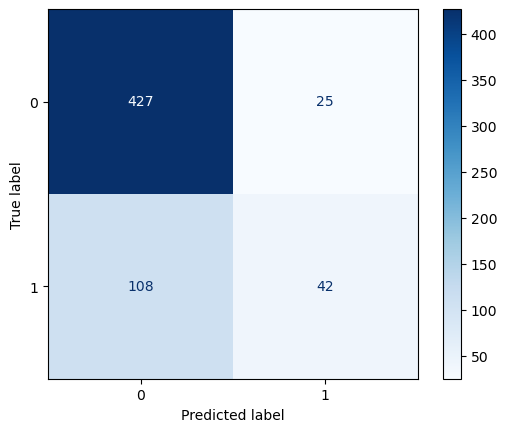

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the validation set
y_val_pred = neigh.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=neigh.classes_)
disp.plot(cmap='Blues', values_format='.0f')

plt.show()


In [184]:
from sklearn.metrics import classification_report

y_val_pred = neigh.predict(X_val)

In [185]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       535
           1       0.28      0.63      0.39        67

    accuracy                           0.78       602
   macro avg       0.61      0.71      0.63       602
weighted avg       0.87      0.78      0.81       602



In [186]:
sensitivity = 45/(45+105)   # = TP/(TP+FN)
specificity = 404/(404+48)   # = TN/(TN+FP)
print(sensitivity, specificity)

0.3 0.8938053097345132


In [187]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")    # I'll include this so you can see the progress of the function as it runs
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    # calculate accuracy
    accu = class_knn.score(X_test, y_test)
    return accu

In [188]:
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


In [189]:
test

,k,accu
0,1,0.691030
1,3,0.709302
2,5,0.737542
3,7,0.744186
4,9,0.754153
5,11,0.754153
6,13,0.750831
7,15,0.747508
8,17,0.742525
9,19,0.744186


In [190]:
test = test.sort_values(by=['accu'], ascending=False)
test

,k,accu
4,9,0.754153
5,11,0.754153
6,13,0.750831
7,15,0.747508
3,7,0.744186
9,19,0.744186
10,21,0.744186
8,17,0.742525
2,5,0.737542
1,3,0.709302


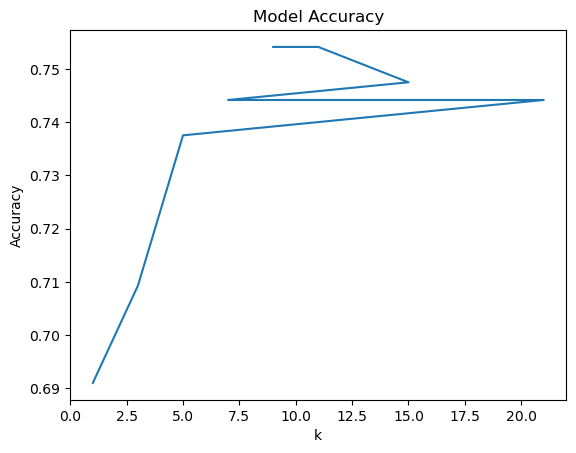

In [191]:
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

## Adjusting the threshold

In [192]:
test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)

In [193]:
test_probabilities = pd.DataFrame(test_probs, columns = ['bad_zscore_prob', 'good_zscore_prob'])
test_probabilities

,bad_zscore_prob,good_zscore_prob
0,0.473684,0.526316
1,0.947368,0.052632
2,0.947368,0.052632
3,0.684211,0.315789
4,0.736842,0.263158
...,...,...
597,0.526316,0.473684
598,0.368421,0.631579
599,0.789474,0.210526
600,0.684211,0.315789


In [194]:
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': [test_probabilities['good_zscore_prob'][i] if test_preds[i]==1 else test_probabilities['bad_zscore_prob'][i] for i in range(len(test_preds))]})

In [195]:
final_model.head()

,actual_class,pred_class,pred_prob
0,1,1,0.526316
1,0,0,0.947368
2,0,0,0.947368
3,0,0,0.684211
4,0,0,0.736842


In [196]:
final_model['pos_pred'] = [final_model.pred_prob[i] if final_model.pred_class[i]==1 else 1-final_model.pred_prob[i] for i in range(len(final_model.pred_class))]

In [197]:
final_model.head()

,actual_class,pred_class,pred_prob,pos_pred
0,1,1,0.526316,0.526316
1,0,0,0.947368,0.052632
2,0,0,0.947368,0.052632
3,0,0,0.684211,0.315789
4,0,0,0.736842,0.263158


In [198]:
final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

In [199]:
import seaborn as sns

sns.displot(final_model, x="pos_pred", kind="kde")

/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [200]:
final_model.pos_pred.value_counts()

pos_pred
0.105263    97
0.052632    91
0.000000    62
0.157895    58
0.473684    48
0.210526    46
0.263158    33
0.421053    31
0.526316    30
0.368421    25
0.578947    24
0.315789    24
0.631579    12
0.789474     9
0.684211     5
0.894737     3
0.947368     2
0.736842     1
0.842105     1
Name: count, dtype: int64

In [201]:
from sklearn.metrics import confusion_matrix

def adjust_thres(x, y, z):
    """
    x=pred_probabilities
    y=threshold
    z=tune_outcome
    """
    thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = confusion_matrix(z, thres)  
    print(con_mat)

In [202]:
confusion_matrix(final_model.actual_class, final_model.pred_class)

array([[406,  45],
       [109,  42]])

In [203]:
adjust_thres(final_model.pos_pred, .9, final_model.actual_class)   # higher threshold 

[[450   1]
 [150   1]]


In [204]:
adjust_thres(final_model.pos_pred, .3, final_model.actual_class) # lower threshold 

[[336 115]
 [ 51 100]]


In [205]:
adjust_thres(final_model.pos_pred, .38, final_model.actual_class) 

[[365  86]
 [ 71  80]]


In [206]:
# Assuming 'neigh' is your kNN classifier
y_val_probabilities = neigh.predict_proba(X_val)[:, 1]


In [207]:
# Adjust the threshold
adjusted_threshold = 0.3  # Set your desired threshold
y_val_adjusted = (y_val_probabilities >= adjusted_threshold).astype(int)


In [208]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_adjusted = confusion_matrix(y_val, y_val_adjusted)
report_adjusted = classification_report(y_val, y_val_adjusted)

print("Confusion Matrix (Adjusted):")
print(conf_matrix_adjusted)

print("\nClassification Report (Adjusted):")
print(report_adjusted)


Confusion Matrix (Adjusted):
[[350 102]
 [ 65  85]]

Classification Report (Adjusted):
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       452
           1       0.45      0.57      0.50       150

    accuracy                           0.72       602
   macro avg       0.65      0.67      0.66       602
weighted avg       0.75      0.72      0.73       602



Evaluation Metrics

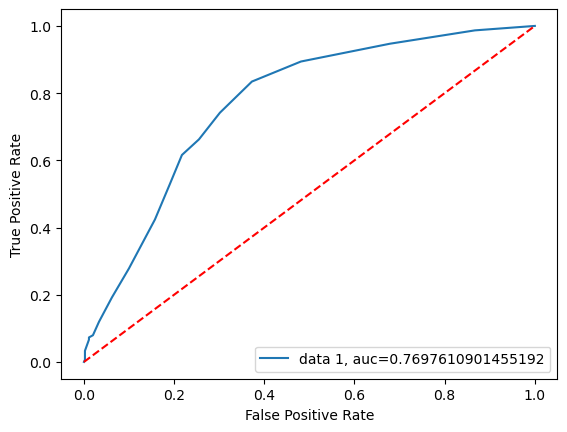

In [210]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, final_model.pos_pred)
auc = metrics.roc_auc_score(y_test, final_model.pos_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()